## MLB data analysis 1: Using the career split data

In [179]:
import pandas as pd;
import numpy as np;

from matplotlib import pyplot as plt
plt.style.use('ggplot');
import scipy.stats as stats
import scipy as sp;

columns_career = ["ID", "Name", "Situation", "G", "AB", "R", "H", "2B", "3B", "HR", "RBI", "BB", "IBB", "SO", "HBP", "SH", \
                 "SF", "XI", "ROE", "GDP", "SB", "CS", "AVG", "OBP", "SLG"]; # len() = 25
columns_dtype = [str]*3 + [np.float64]*22;

columns_dtype_dict = dict(zip(columns_career, columns_dtype));

In [38]:
df_player_career_split = pd.read_csv("player_career_split_data.csv", usecols = columns_career, dtype = columns_dtype_dict);

## Testing if two binomial distributions are equal

We first formulate what we are trying to test. Suppose a batter's hitting average in non-RISP and RISP are $p_1$ and $p_2$, respectively, then our null hypothesis is

$$H_0: p_1 = p_2, \quad\text{ i.e. a batter is no stronger in clutch (RISP)}.$$

On the other hand, our alternative hypothesis is

$$H_A: p_1 < p_2, \quad\text{ i.e. a batter is stronger in clutch (RISP)}.$$

According to the literature (see, for instance, [here](https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other) for a stackoverflow discussion), there are two major ways to determined if the two binomial distributions are identical.

1. Approximate the binomial distribution to a normal distribution. Suppose the sample size is $N$, and the probability is $p$, then as a rule of thumb, the binomial distribution is "close enough" to a normal distribution only if $Np, N(1-p)$ are both about 10 or larger. Since in baseball $p < 0.5$, we requested $N > 30$ for a better approximation.

    For a player, if the AB of non-RISP and RISP are $N_1$ and $N_2$, respectively, then the weighted average is $\displaystyle \hat p = \frac{N_1p_1 + N_2p_2}{N_1 + N_2}$, and the variance is $\displaystyle \sigma^2 = \hat p(1 - \hat p)\left(\frac{}{}\right)$. Under the assumption that $p_1 = p_2$, one can estimate the variance of the distributions and obtain the $z$-value as
    
    $$z = \frac{\hat p_2 - \hat p_1}{\sqrt{\hat p(1-\hat p)\left(N_1^{-1} + N_2^{-1}\right)}}.$$
    
    By passing the $z$-value to the error function, once can obtain the one-sided $p$-value. See the NIST document at the end for more information.
    
2. Using the Fisher's exact test. First, we have to set up a $2\times2$ contingency matrix, which is
    $$\begin{bmatrix}\#\{\text{non-hits in non-RISP}\} & \#\{\text{non-hits in RISP}\} \\ \#\{\text{hits in non-RISP}\} & \#\{\text{hits in RISP}\}\end{bmatrix}.$$
    
    Fisher's idea is based on a model on hypergeobetric series, but we skip the details. Using the built-in function from scipy, we can compute an one-sided $p$-value.

Comparing methods 1 and 2, Fisher's test had no assumptions which approximates a binomial distribution as a normal distribution, so it can be appropriate for smaller sample size, but it becomes slow for larger sample size.

In [156]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "RISP"];
temp = temp[temp["AB"] >= AB_threshold];

RISP_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");
# RISP_comp.loc[0] # Total: 3771, 12364, 964, 2956
#.merge(df_player_career_split[df_player_career_split["Situation"] == "RISP"], on = "ID")


print(RISP_comp.shape[0]-1)


6995


### 2. The Fisher exact method

In [180]:
p_RISP = [];
for i in range(RISP_comp.shape[0]):
    temp_list = RISP_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res = stats.fisher_exact([[temp_list[1]-temp_list[3], temp_list[3]], \
                              [temp_list[0]-temp_list[2]-(temp_list[1]-temp_list[3]), temp_list[2]-temp_list[3]]], \
                             alternative="greater")[1];
    p_RISP.append(res);

### Tracing $p$-values throughout the player database

The assumption we are actually interested is:

*For every batter, the null hypothesis $H_0: p_\text{RISP} = p_\text{non-RISP}$ holds true*.

In this case, if we use either method above, the $p$-values computed by each player should be an uniform distribution in $[0,1]$. We can test this hypothesis using the $\chi$-squared test.

KstestResult(statistic=0.08506902691461204, pvalue=1.7046376806880028e-44)

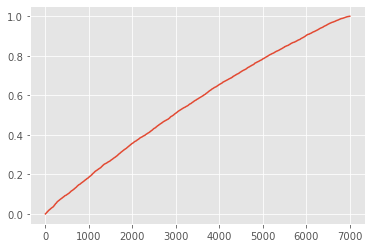

In [158]:
test = sorted(p_RISP)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) # 1.70e-44
# This means that the null hypothesis should be rejected... But wait?

### Now, let us try to implement the method "1. Approximation to normal distribution"

In [192]:
def Phi(x): # The cdf of the normal distribution N(0,1).
    return (1+sp.special.erf(x/2**0.5))/2;

def Binomial_p_val(x1, x2, N1, N2, adjust=False): # In our application, N1: non-RISP, N2: RISP
    p1 = x1/N1;
    p2 = x2/N2;
    if adjust:
        p2 = p2/theta;
    
    phat = (p1*N1 + p2*N2)/(N1 + N2);
    return Phi((p2-p1)/np.sqrt(phat*(1-phat)*(1/N1+1/N2)));

In [201]:
p_RISP_2 = [];
for i in range(RISP_comp.shape[0]):
    temp_list = RISP_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], True);
    p_RISP_2.append(res);

KstestResult(statistic=0.013475397125518318, pvalue=0.1561262243686563)

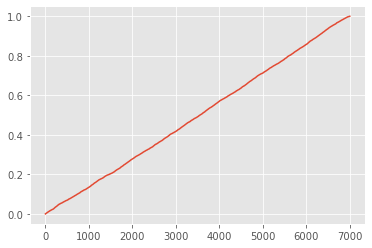

In [202]:
test = sorted(p_RISP_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

### It turns out that the hitting average at RISP is globally higher than at non-RISP. Can we adjust to that?

Unfortunately, things get a bit messy on that. I do not know of any rigorous mathematical model for that, but let's try...

In [172]:
# First idea: Try to multiply the AVG by a constant factor to balance the average in non-RISP and RISP.
# Equivalently, p_RISP = theta * p_nonRISP
test1 = [sum(RISP_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #12715568, 3348091, 3022597, 802629

test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2633, .2655, .2626
#theta = test1[1]/test1[2]; # 1.0111716751056685
theta_RISP = 1.0111716751056685;

In [203]:
p_RISP_2[0]

0.9936074251999503

## Some statistical references

- How can we determine whether two processes produce the same proportion of defectives? From NIST
    https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm
- Fischer's exact test (have implementation in scipy)
    https://en.wikipedia.org/wiki/Fisher's_exact_test
- Barnard's test (have documentation in scipy, but the function seemed to be removed)
    https://en.wikipedia.org/wiki/Barnard%27s_test
